# Intro to Research Environment

In [1]:
from quantopian.interactive.data.sentdex import sentiment

In [2]:
from quantopian.pipeline.filters.morningstar import Q1500US

In [3]:
type(sentiment)

<class 'blaze.expr.expressions.Field'>

In [4]:
dir(sentiment)

['apply',
 u'asof_date',
 'cast',
 'count',
 'count_values',
 'distinct',
 'drop_field',
 'dshape',
 'fields',
 'head',
 'isidentical',
 'map',
 'ndim',
 'nelements',
 'nrows',
 'nunique',
 'peek',
 'relabel',
 'sample',
 'schema',
 u'sentiment_signal',
 'shape',
 'shift',
 u'sid',
 'sort',
 u'symbol',
 'tail',
 u'timestamp']

In [5]:
BAC = symbols('BAC').sid
bac_sentiment = sentiment[ (sentiment.sid==BAC) ]

In [6]:
bac_sentiment.head()

<quantopian>.sentdex.sentiment[<quantopian>.sentdex.sentiment.sid == 700].head(10)

In [7]:
bac_sentiment.peek()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,BAC,6.0,700,2012-11-14,2012-11-15
1,BAC,1.0,700,2012-11-15,2012-11-16
2,BAC,-1.0,700,2012-11-16,2012-11-17
3,BAC,-1.0,700,2012-11-17,2012-11-18
4,BAC,-1.0,700,2012-11-18,2012-11-19
5,BAC,6.0,700,2012-11-19,2012-11-20
6,BAC,6.0,700,2012-11-20,2012-11-21
7,BAC,6.0,700,2012-11-21,2012-11-22
8,BAC,6.0,700,2012-11-22,2012-11-23
9,BAC,6.0,700,2012-11-23,2012-11-24


In [8]:
import blaze

bac_sentiment =  blaze.compute(bac_sentiment)
type(bac_sentiment)

<class 'pandas.core.frame.DataFrame'>

In [9]:
bac_sentiment.head()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,BAC,6.0,700,2012-11-14,2012-11-15
1,BAC,1.0,700,2012-11-15,2012-11-16
2,BAC,-1.0,700,2012-11-16,2012-11-17
3,BAC,-1.0,700,2012-11-17,2012-11-18
4,BAC,-1.0,700,2012-11-18,2012-11-19


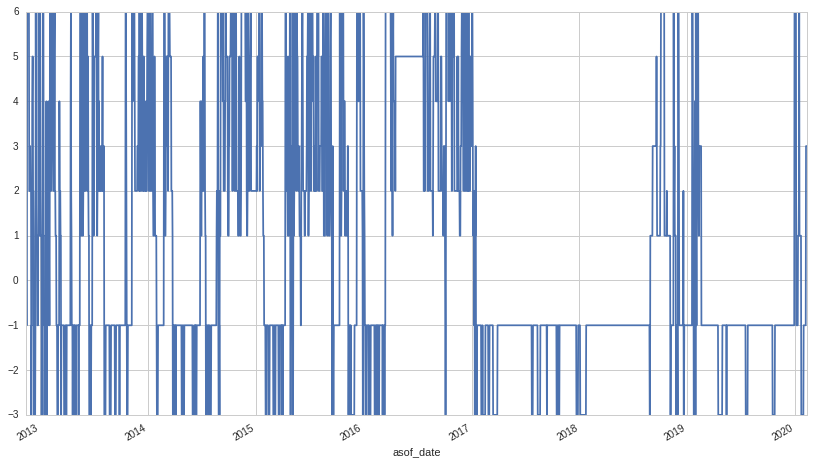

In [10]:
bac_sentiment.set_index('asof_date', inplace=True)
bac_sentiment['sentiment_signal'].plot()

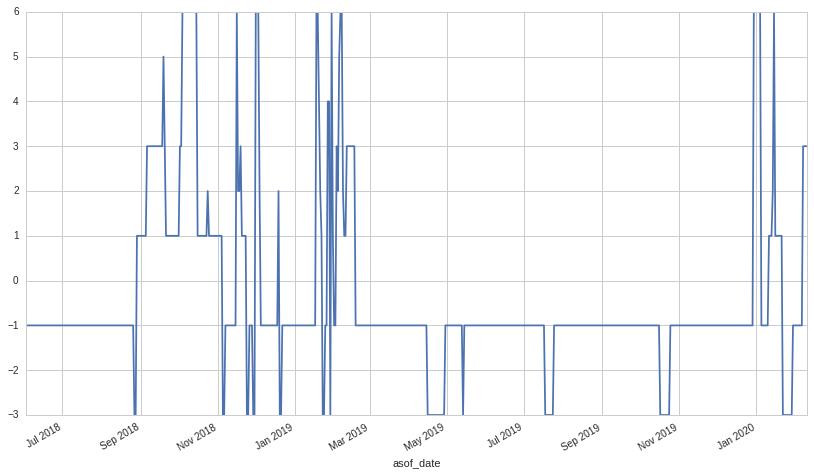

In [11]:
bac_sentiment = bac_sentiment[ (bac_sentiment.index > '2018-06-01') ]
bac_sentiment['sentiment_signal'].plot()

# Pipeline Basics

In [12]:
from quantopian.pipeline import Pipeline
def make_pipeline():
    return Pipeline()

In [13]:
from quantopian.research import run_pipeline

my_pipe = make_pipeline()
result = run_pipeline(
    my_pipe,
    start_date = '2017-05-05',
    end_date = '2017-05-05'
)

In [14]:
result.head()

Empty DataFrame
Columns: []
Index: [(2017-05-05 00:00:00+00:00, Equity(2 [ARNC])), (2017-05-05 00:00:00+00:00, Equity(21 [AAME])), (2017-05-05 00:00:00+00:00, Equity(24 [AAPL])), (2017-05-05 00:00:00+00:00, Equity(25 [ARNC_PR])), (2017-05-05 00:00:00+00:00, Equity(31 [ABAX]))]

In [15]:
len(result)

8392

In [16]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment

def make_pipeline():
    # fator returns
    sentiment_factor = sentiment.sentiment_signal.latest
    
    # our universe is made up of stock that have non-null sentiment signal that was updated in
    # the last day, are not within 2 days of an earnings announcement, are not announced acquisition
    # targets, and are in the Q1500US.
    universe = (Q1500US() & sentiment_factor.notnull())
    
    # A classifier to separate the stocks into quantiles based on setiment rank
    
    # go short the stocks in the 0th quantile, and long the stocks in the 2nd quantile
    pipe = Pipeline(
        columns={
            'sentiment': sentiment_factor,
            'longs': (sentiment_factor >= 4),
            'shorts': (sentiment_factor <= -2)
        },
        screen=universe
    )
    
    return pipe

In [17]:
result = run_pipeline(make_pipeline(), start_date = '2015-01-01', end_date = '2016-01-01')

In [18]:
result.head()

longs  sentiment shorts
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   False        2.0  False
                          Equity(24 [AAPL])  False        2.0  False
                          Equity(62 [ABT])   False        1.0  False
                          Equity(67 [ADSK])   True        6.0  False
                          Equity(76 [TAP])   False       -3.0   True

# Alphalens Analysis

In [19]:
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = '2014-01-01', end_date = '2016-01-01', fields='open_price')

In [20]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result['sentiment'],
                                         prices = pricing,
                                         quantiles = 2,
                                         periods = (1,5,10))

factor_data.head()

Dropped 4.4% entries from factor data: 4.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                             
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.014515  0.010059 -0.057359   
                          Equity(24 [AAPL]) -0.027830  0.011495 -0.039142   
                          Equity(62 [ABT])  -0.009953  0.011058 -0.026924   
                          Equity(67 [ADSK]) -0.015152 -0.021312 -0.074426   
                          Equity(76 [TAP])  -0.016752  0.045275 -0.005899   

                                             factor  factor_quantile  
date                      asset                                       
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])      2.0                2  
                          Equity(24 [AAPL])     2.0                2  
                          Equity(62 [ABT])      1.0                1  
                          Equity(67 [ADSK])     6.0                2  
                          Equity(76 [TAP])     -3.0                1

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.0,1.0,-1.518792,0.947564,75965,61.94297
2,1.0,6.0,3.234038,1.914371,46672,38.05703


Returns Analysis


,1D,5D,10D
Ann. alpha,0.017,0.024,0.020
beta,-0.002,-0.021,-0.030
Mean Period Wise Return Top Quantile (bps),0.859,1.024,0.866
Mean Period Wise Return Bottom Quantile (bps),-0.436,-0.505,-0.393
Mean Period Wise Spread (bps),1.294,1.525,1.254


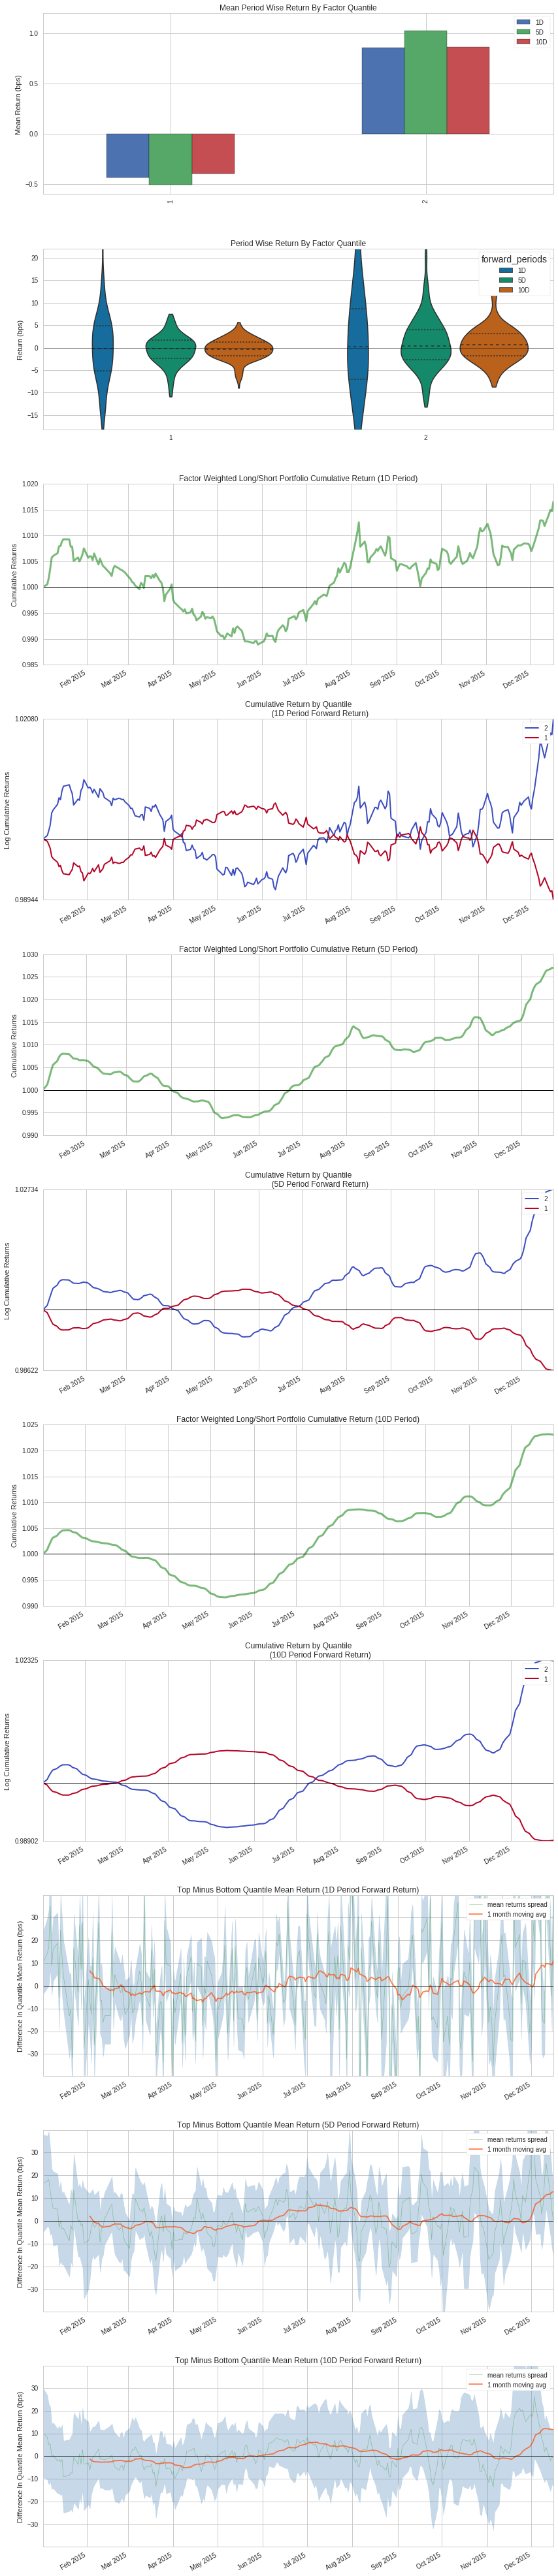

Information Analysis


,1D,5D,10D
IC Mean,0.005,0.015,0.018
IC Std.,0.059,0.059,0.058
Risk-Adjusted IC,0.092,0.247,0.306
t-stat(IC),1.429,3.847,4.760
p-value(IC),0.154,0.000,0.000
IC Skew,-0.080,-0.110,-0.022
IC Kurtosis,0.245,-0.237,-0.484


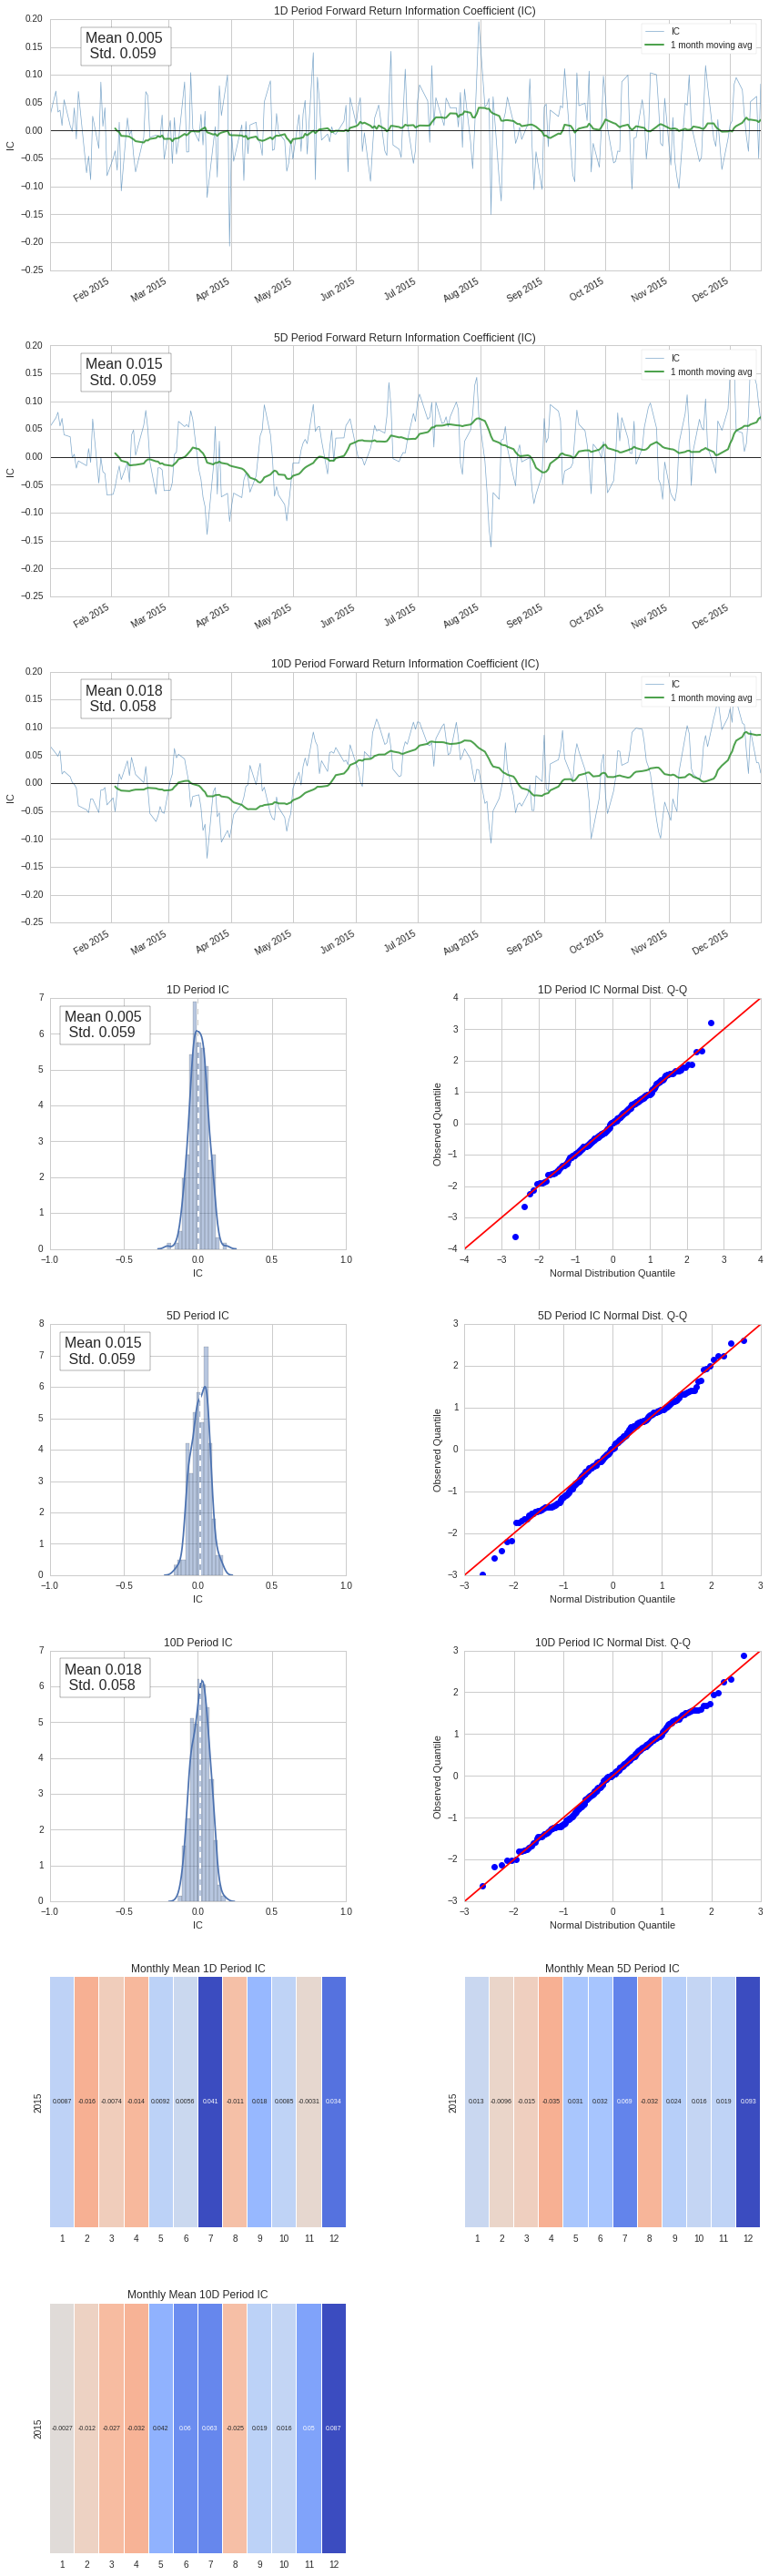

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.116,0.03,0.081
Quantile 2 Mean Turnover,0.183,0.05,0.130


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.894,0.728,0.621


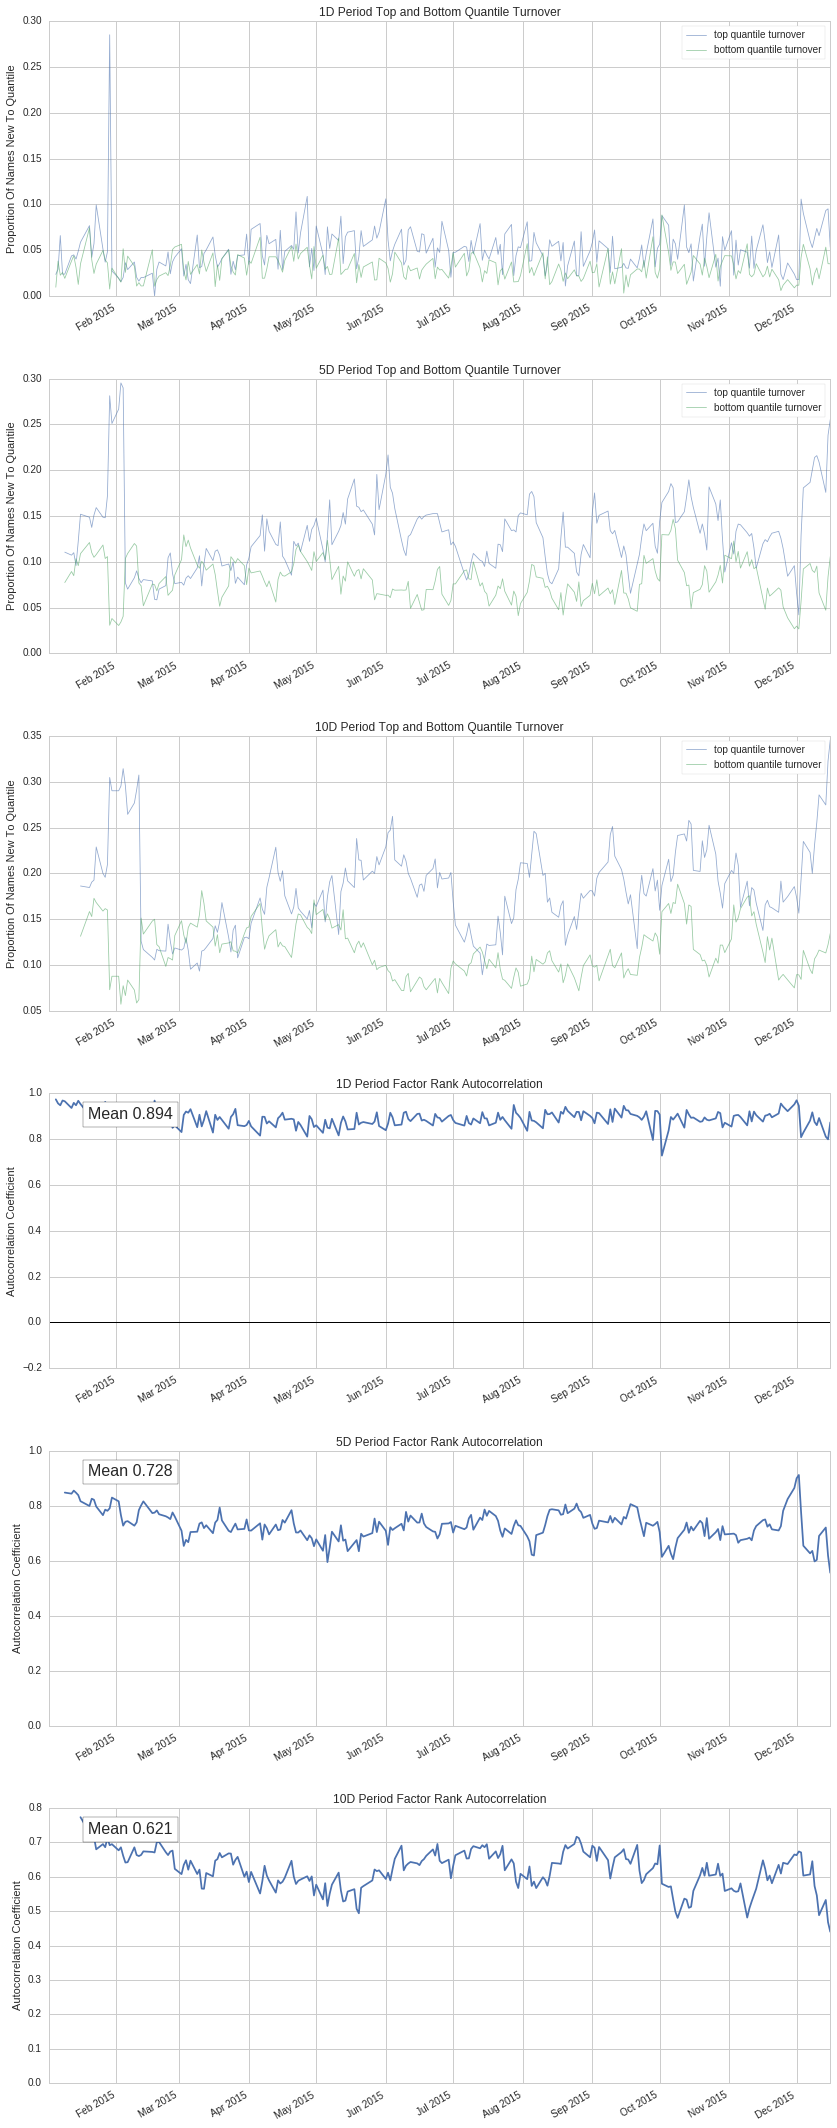

In [21]:
alphalens.tears.create_full_tear_sheet(factor_data, long_short=True)

In [22]:
bt = get_backtest('5e42fc5d99e88147d99315fe')

100% Time:  0:00:01|##########################################################|


Start date,2015-01-05
End date,2015-12-31
Total months,11
,Backtest
Annual return,0.101%
Cumulative returns,0.1%
Annual volatility,0.655%
Sharpe ratio,0.16
Calmar ratio,0.17
Stability,0.00
Max drawdown,-0.605%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.60,2015-01-13,2015-09-28,2015-12-03,233
1,0.33,2015-12-04,2015-12-28,NaT,NaN
2,0.02,2015-01-05,2015-01-06,2015-01-07,3
3,0.01,2015-01-07,2015-01-08,2015-01-12,4
4,0.00,2015-01-05,2015-01-05,2015-01-05,1


/venvs/py27/local/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Fall2015,-0.01%,-0.13%,0.07%
New Normal,0.00%,-0.14%,0.25%


Top 10 long positions of all time,max
AVP-660,1.19%
JCP-4118,0.88%
ZNGA-42277,0.86%
S-2938,0.83%
SIRI-11901,0.83%
DNR-15789,0.77%
GRPN-42118,0.74%
FTR-2069,0.73%
AMD-351,0.71%
ARNA-21724,0.69%


Top 10 short positions of all time,max
RF-34913,-0.96%
S-2938,-0.88%
AVP-660,-0.86%
WIN-27019,-0.79%
SIRI-11901,-0.77%
ZNGA-42277,-0.70%
FCX-13197,-0.64%
AMD-351,-0.60%
MNKD-26524,-0.59%
GNW-26323,-0.56%


Top 10 positions of all time,max
AVP-660,1.19%
RF-34913,0.96%
JCP-4118,0.88%
S-2938,0.88%
ZNGA-42277,0.86%
SIRI-11901,0.83%
WIN-27019,0.79%
DNR-15789,0.77%
GRPN-42118,0.74%
FTR-2069,0.73%


/venvs/py27/local/lib/python2.7/site-packages/pyfolio/perf_attrib.py:612: UserWarning: This algorithm has relatively high turnover of its positions. As a result, performance attribution might not be fully accurate.

Performance attribution is calculated based on end-of-day holdings and does not account for intraday activity. Algorithms that derive a high percentage of returns from buying and selling within the same day may receive inaccurate performance attribution.

  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

Summary Statistics,
Annualized Specific Return,-0.14%
Annualized Common Return,0.26%
Annualized Total Return,0.12%
Specific Sharpe Ratio,-0.23


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,0.00,0.01%,0.01%
consumer_cyclical,-0.00,-0.01%,-0.01%
financial_services,-0.00,0.02%,0.02%
real_estate,0.00,0.02%,0.02%
consumer_defensive,0.00,-0.01%,-0.01%
health_care,-0.00,0.03%,0.03%
utilities,0.00,0.00%,0.00%
communication_services,0.00,0.06%,0.06%
energy,-0.00,0.19%,0.19%
industrials,0.00,0.00%,0.00%


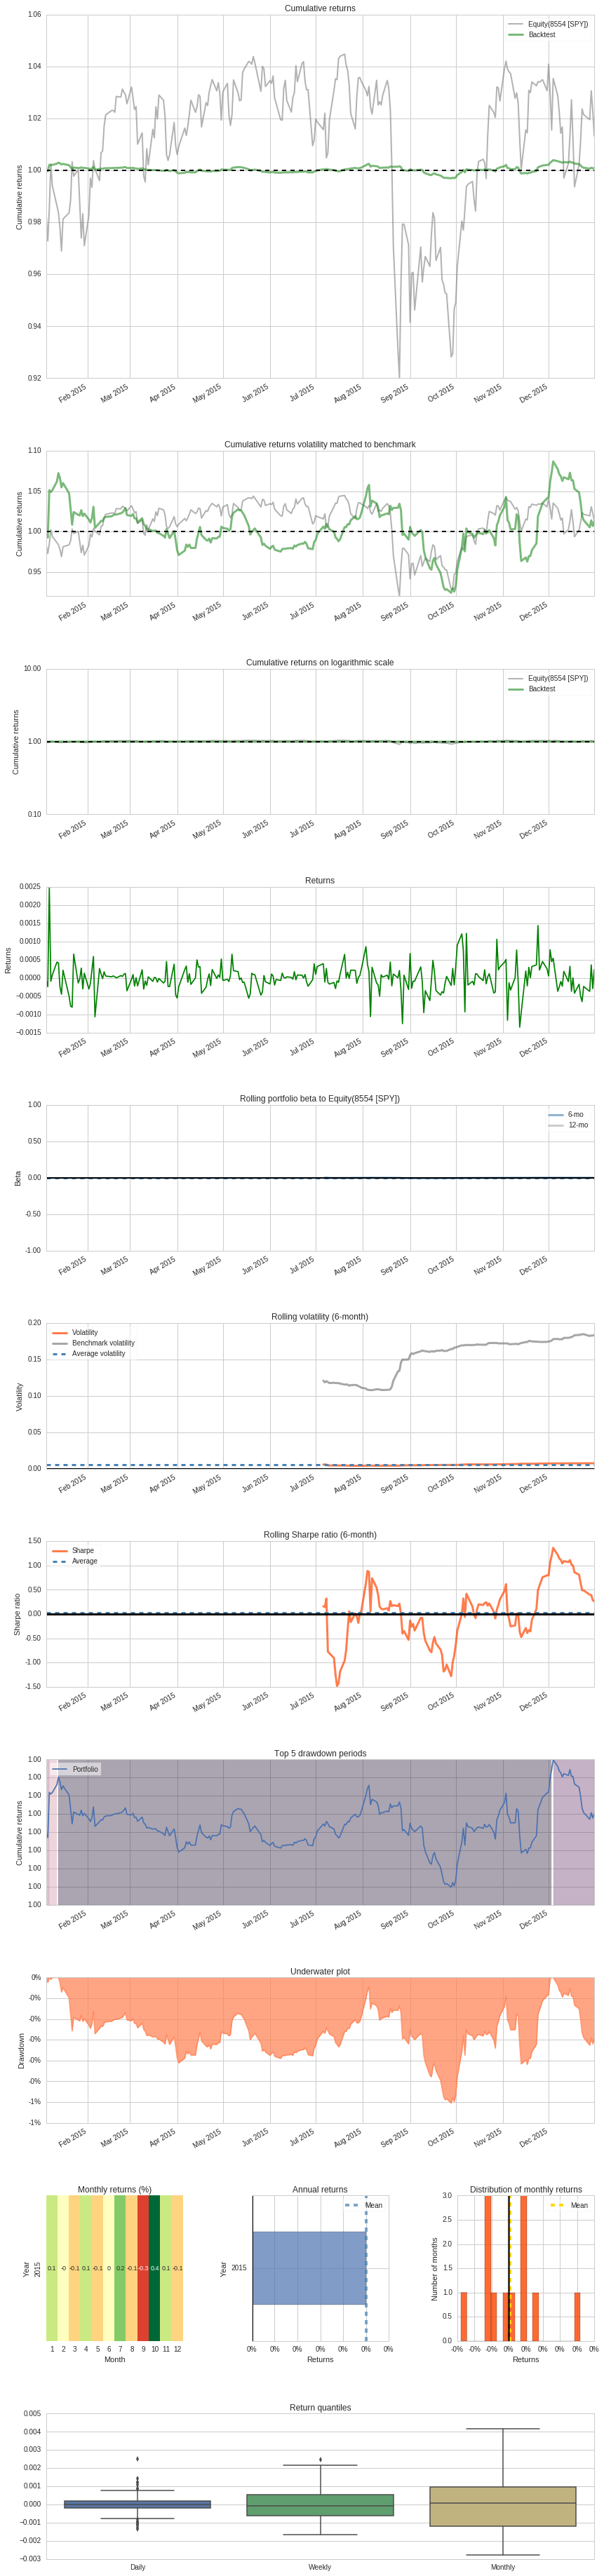

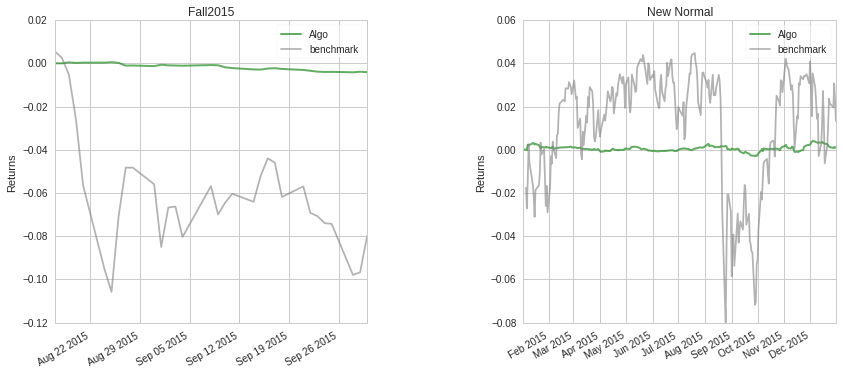

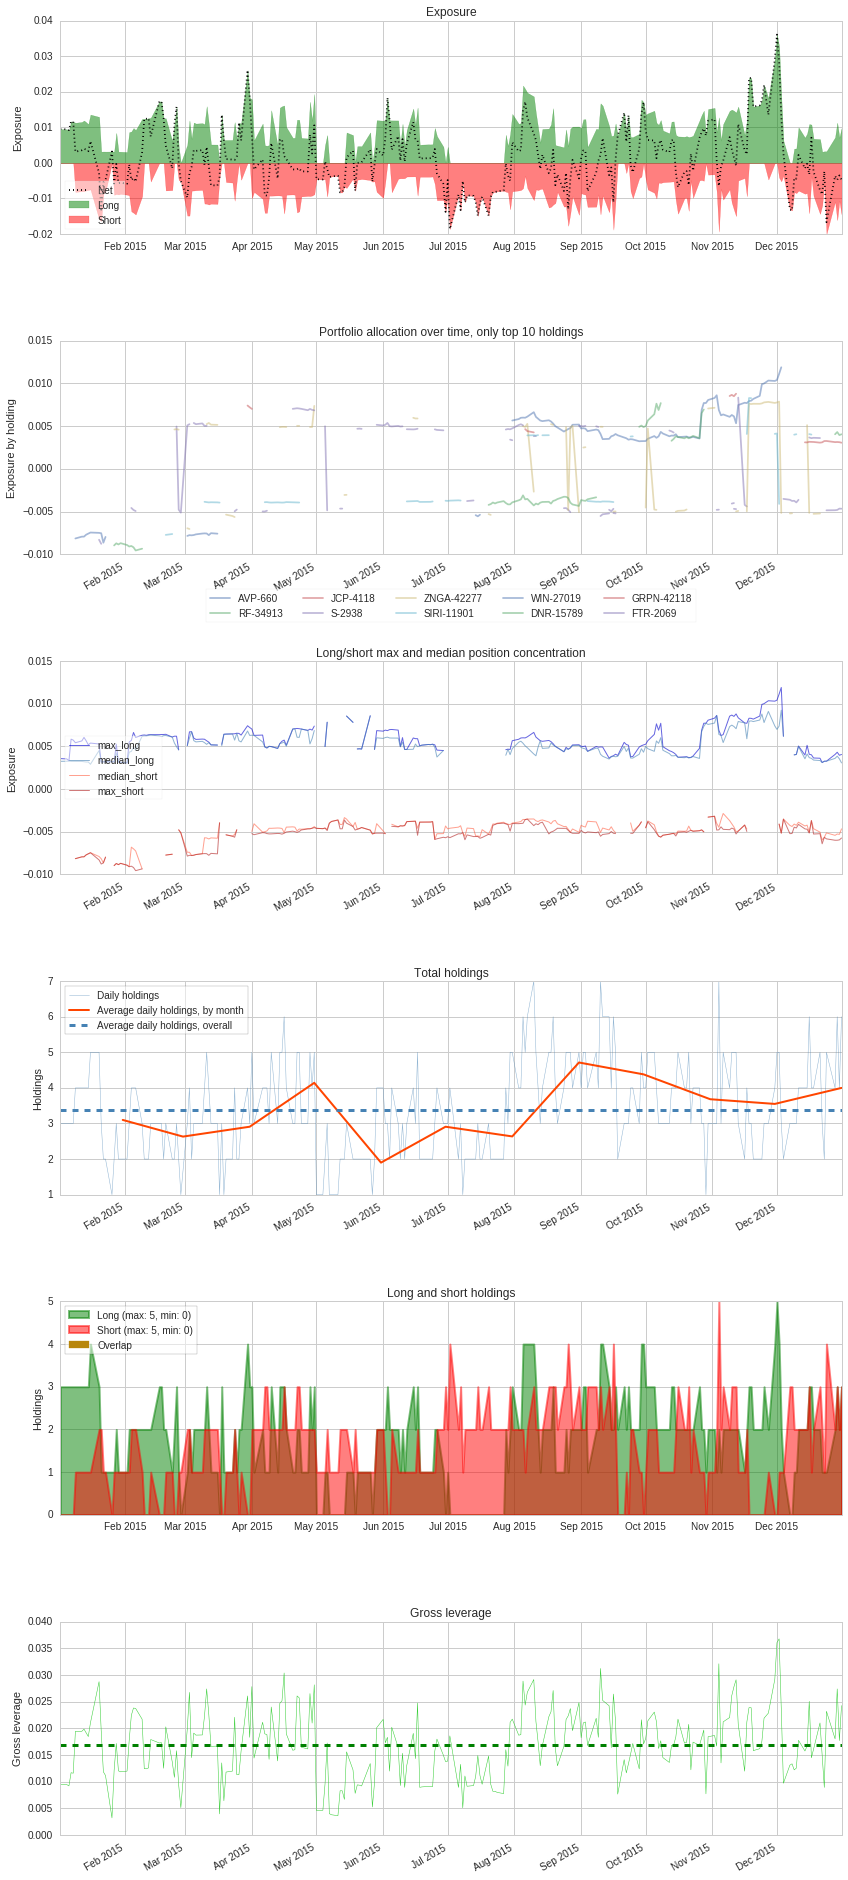

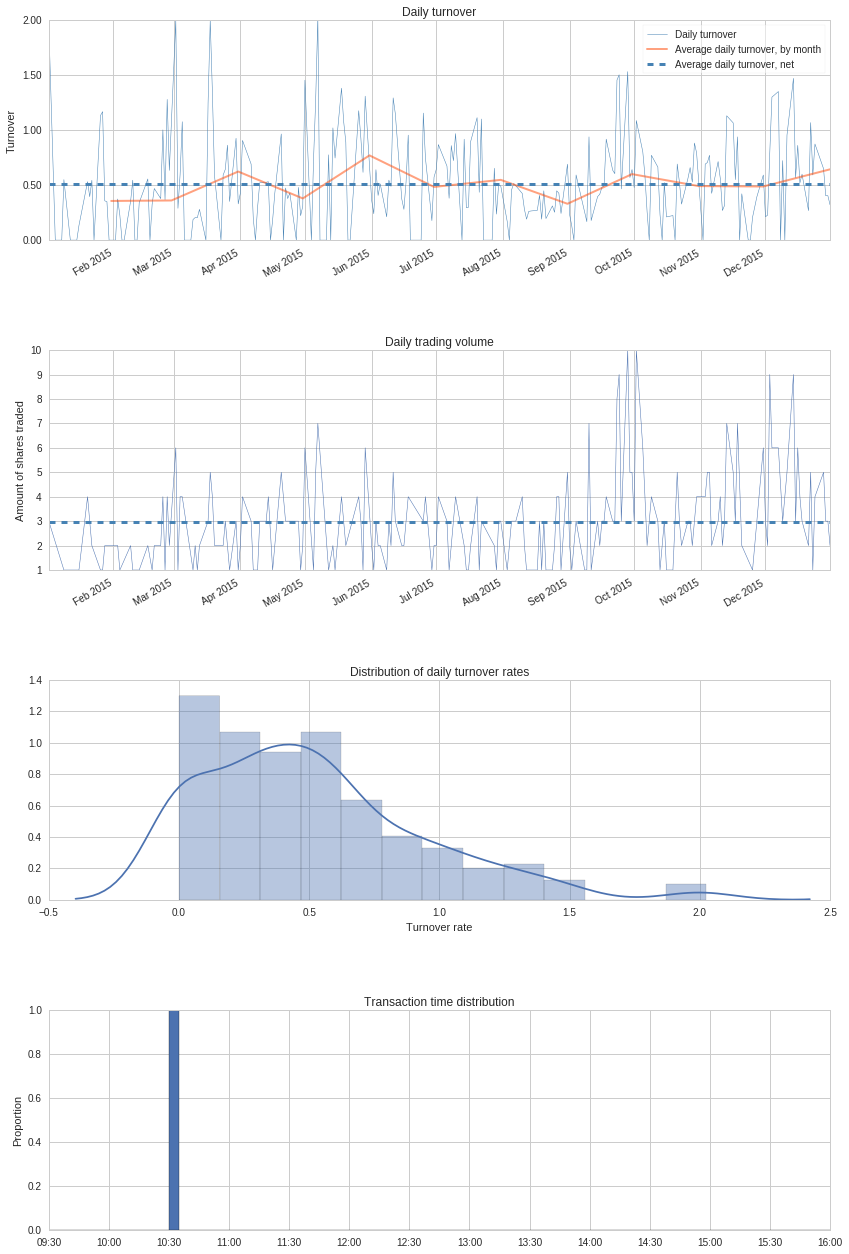

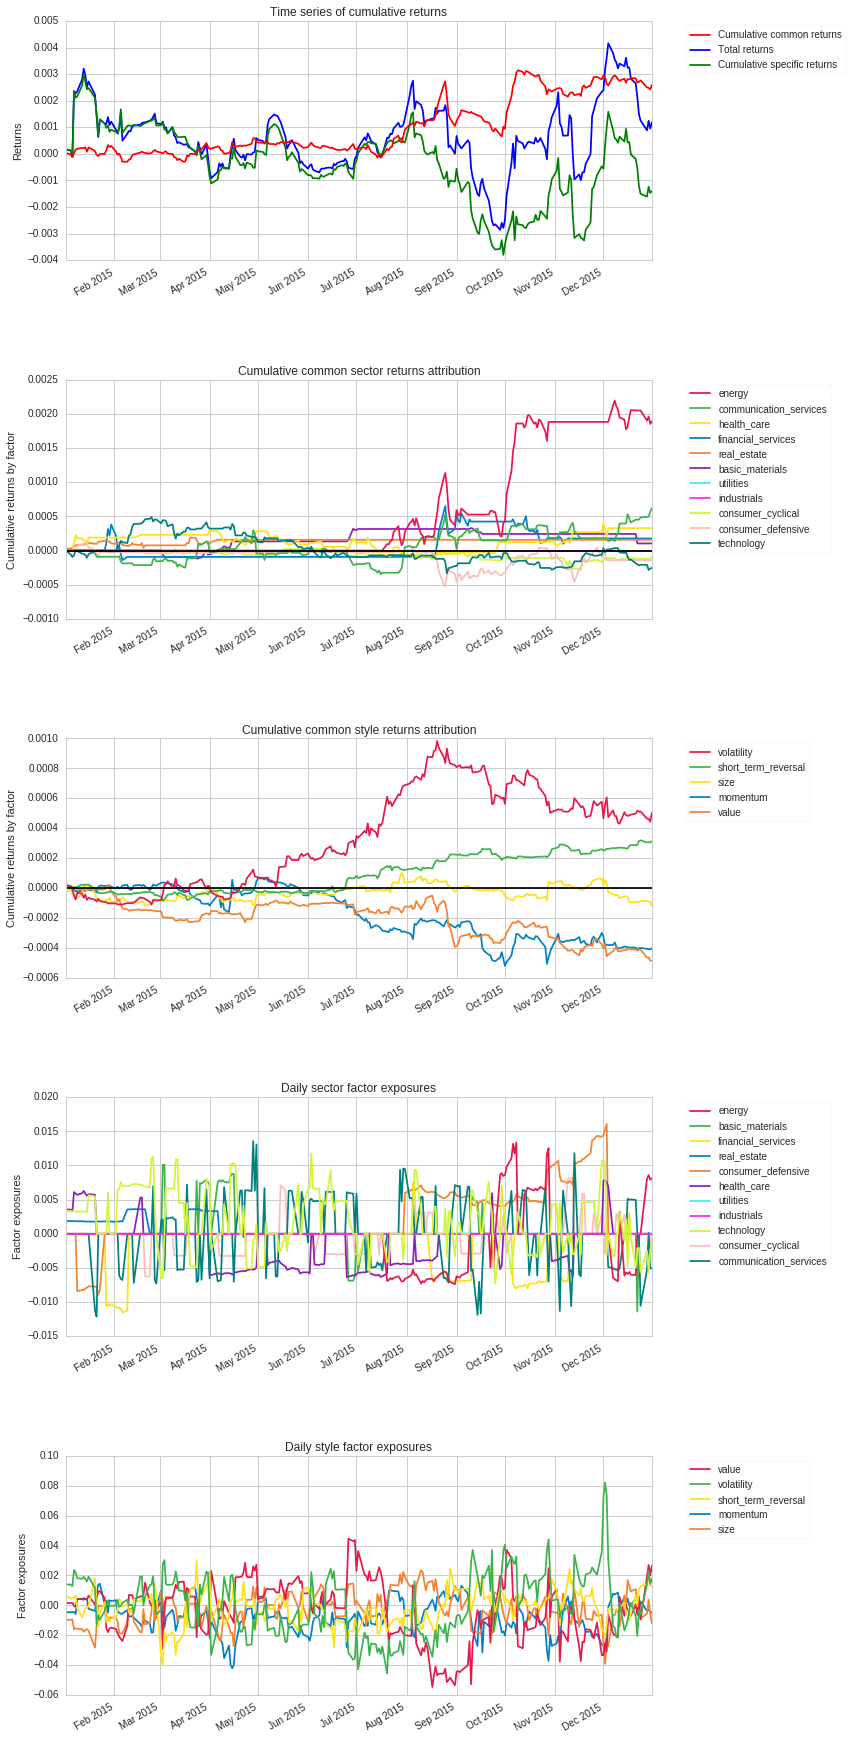

In [23]:
bt.create_full_tear_sheet()

## Simplified work flow

1. <b>Universe Selection:</b> define the universe of tradeable components; the universe should be broad but have some degree of self similarity to enable extraction of relative value. It should also eliminate hard to trade or prohibited instruments.
<br><br>
2. <b>Single Alpha Factor Modeling:</b> define and evaluate individual expressions which rank the cross section of equities in your universe.
<br><br>
3. <b>Alpha Combination:</b> combine many single alphas into a final alpha which has stronger prediction power than the best single alpha. This is often due to the noise in each alpha being canceled out by noise in other alphas, allowing signal to come through.
<br><br>
4. <b>Risk Model:</b> define and calculate the set of risk factors you want to use to constrain your portfolio.
<br><br>
5. <b>Portfolio Construction:</b> implement a process which takes your final combined alpha and your risk model and produces a target portfolio that minimizes risk under your model.
<br><br>
6. <b>Execution:</b> implement a trading process to transition the current portfolio (if any) to the target portfolio.
